## Multiclass Automated Speech Recognition using a Baseline and an Advanced Model

Download the speech image transformed data from GitHub and unzip it in the current directory:

In [65]:

# get the data from github and unzip
# !wget https://raw.githubusercontent.com/andrsn/data/main/speechImageData.zip
# !unzip -q /content/speechImageData.zip


### 1. Import Libraries and define constants

In [66]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation, Input, Conv2D, MaxPooling2D, Flatten, Softmax
from keras import optimizers, regularizers


NUM_CLASSES = 12
BATCH_SIZE = 128
IMG_SIZE = (98, 50)

### 2. Data Preprocessing

* Create usable keras dataset components from the extracted files. 

* In total, there are 12 classes of different spoken words and the spectrograms, which form the input image data are of size 98x50 pixels.

In [67]:
# Load the data

train_ds = tf.keras.utils.image_dataset_from_directory(
    directory='speechImageData/TrainData',
    labels='inferred',
    color_mode="grayscale",
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    directory='speechImageData/ValData',
    labels='inferred',
    color_mode="grayscale",
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

# Extract the  training input images and output class labels
x_train = []
y_train = []
for images, labels in train_ds.take(-1):
    x_train.append(images.numpy())
    y_train.append(labels.numpy())

x_train = np.concatenate(x_train, axis=0)
y_train = np.concatenate(y_train, axis=0)

print(y_train)

# Extract the validation input images and output class labels
x_val = []
y_val = []
for images, labels in val_ds.take(-1):
    x_val.append(images.numpy())
    y_val.append(labels.numpy())

x_val = np.concatenate(x_val, axis=0)
y_val = np.concatenate(y_val, axis=0)

print(y_val)


Found 2001 files belonging to 12 classes.
Found 1171 files belonging to 12 classes.
[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


2024-03-12 05:12:40.387363: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-12 05:12:40.430803: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### 3. Model Design

We now attempt to approach the problem with five tasks:

#### Task 1: Baseline Model

The following are its features:

* One Conv2D, BatchNormalization, MaxPooling2D, and Dropout layer.
* Accuracy of atleast 0.6 on the validation set.


In [68]:
# define t1 model
from keras.metrics import Accuracy

def t1_model(num_layers, num_filters, passthrough=False):
    # number of convolutional filters
    input_num_filters = 32
    fully_connected_num_filters = 1024

    # define model
    model = Sequential()

    # input layer
    model.add(Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 1)))
    model.add(Conv2D(input_num_filters, kernel_size =(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size =(2, 2), strides=(2, 2), padding='same'))

    # hidden layers
    for i in range(num_layers):
        if passthrough:
            model.add(Conv2D(num_filters[i], kernel_size =(3, 3), padding='same', activation='relu'))
        else:
            model.add(Conv2D(num_filters, kernel_size =(3, 3), padding='same', activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size =(2, 2), strides=(2, 2), padding='same'))

    # fully connected layer
    model.add(Flatten())
    model.add(Dense(fully_connected_num_filters, activation='relu'))
    model.add(Dropout(0.2))

    # output layer
    model.add(Dense(NUM_CLASSES, activation='softmax'))

    # set optimizer
    opt = optimizers.Adam(learning_rate=0.001)
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=[Accuracy()])

    return model

hidden_num_layers = [2, 3, 4, 5]
hidden_num_filters = [128, 128, 128, 128]
task1_model = t1_model(len(hidden_num_layers), hidden_num_filters, passthrough=True)
# task1_model.summary()

#### T1.A - Model Training

This section trains the deep convolutional network using the Adam algorithm.

In [69]:
history = task1_model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=30, validation_data=(x_val, y_val))

Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 354ms/step - accuracy: 0.0000e+00 - loss: 3.4845 - val_accuracy: 0.0000e+00 - val_loss: 11.5648
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 343ms/step - accuracy: 0.0000e+00 - loss: 1.7568 - val_accuracy: 0.0000e+00 - val_loss: 7.2978
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 340ms/step - accuracy: 0.0000e+00 - loss: 1.2315 - val_accuracy: 0.0000e+00 - val_loss: 4.7638
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 345ms/step - accuracy: 0.0000e+00 - loss: 0.9231 - val_accuracy: 0.0000e+00 - val_loss: 3.7985
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 339ms/step - accuracy: 0.0000e+00 - loss: 0.6116 - val_accuracy: 0.0000e+00 - val_loss: 2.3294
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 329ms/step - accuracy: 3.8150e-05 - loss: 0.4492 - val_accuracy: 0.0000e+00 - val_loss: 2.4261
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 331ms/step - accuracy: 0.0000e+00 - loss: 0.2917 - val_accuracy: 0.0000e+00 - val_loss: 2.0237
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 354ms/

#### T1.B - Plot Training History and Confusion Matrix

Here, we plot the training history and confusion matrix of the baseline model.

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


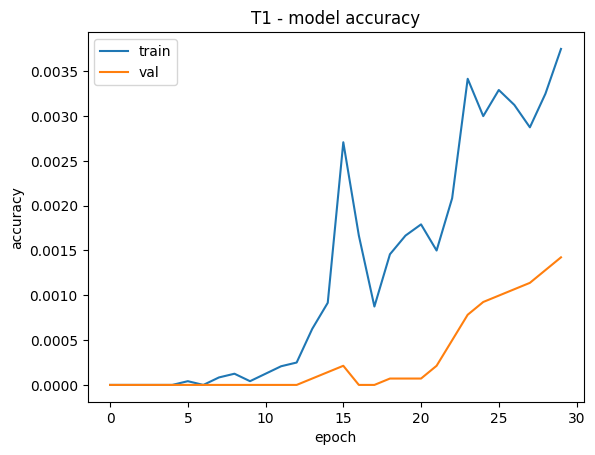

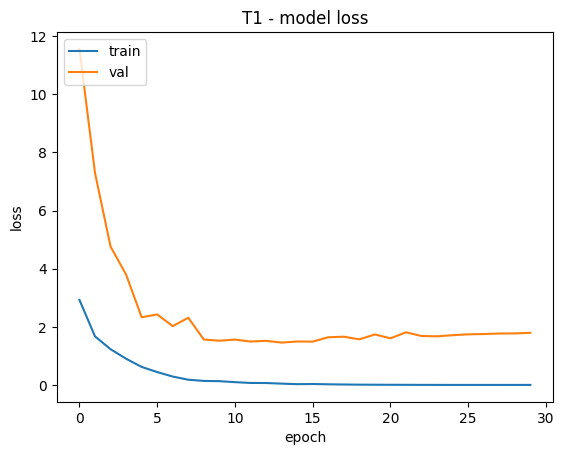

T1 - validation accuracy: 0.001423284993506968
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


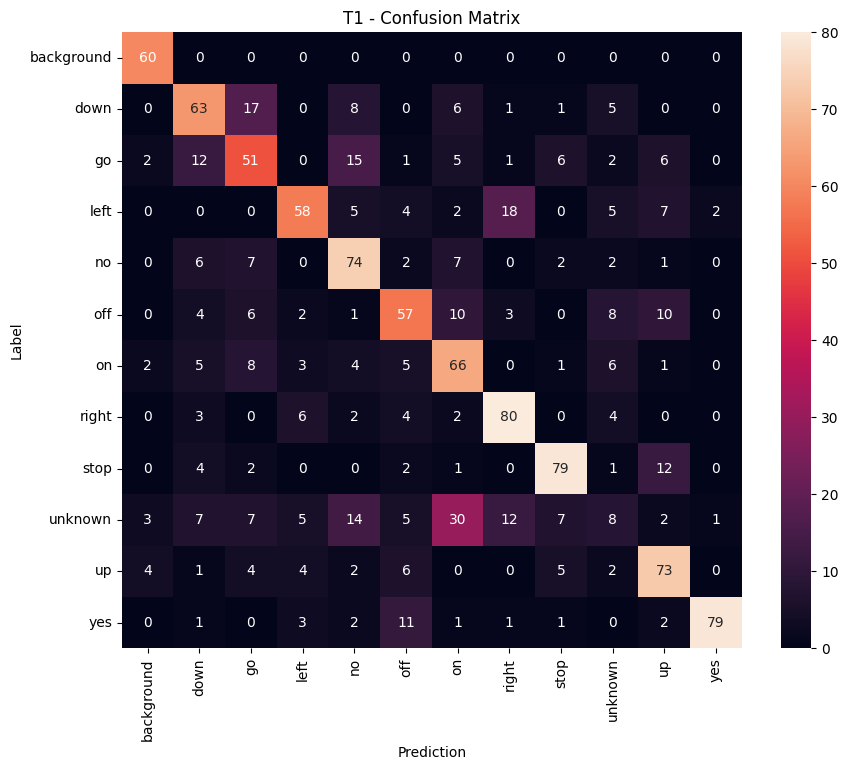

In [70]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('T1 - model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('T1 - model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Print accuracy
score = task1_model.evaluate(x_val, y_val, verbose=0)
print('T1 - validation accuracy:', score[1])

# Print confusion matrix
y_pred = task1_model.predict(x_val)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)
class_labels = list(val_ds.class_names)
confusion_mtx = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=class_labels, yticklabels=class_labels, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.title('T1 - Confusion Matrix')
plt.show()


As we can see, the model is not performing well on the validation set, especially for the class 'unknown'. We now proceed to the next task.
The overall accuracy converges to about 0.67.

#### Task 2: Random Search for Hyperparameter Tuning

We now use random search to find the best hyperparameters for the baseline model. Random search is better than grid search because it is faster and more efficient.
Here, we use the RandomSearchCV class from the scikit-learn library to find the best hyperparameters for the baseline model.

In [73]:
# Use RandomizedSearchCV to find the best hyperparameters
from sklearn.model_selection import RandomizedSearchCV
from scikeras.wrappers import KerasClassifier
import pandas as pd

# define the grid search parameters
param_grid = {
    'num_layers': hidden_num_layers,
    'num_filters': hidden_num_filters,
}

# Create a KerasClassifier
task2_model = KerasClassifier(model=t1_model, epochs=50, batch_size=BATCH_SIZE, verbose=1, num_layers=hidden_num_layers, num_filters=hidden_num_filters)

# Create a RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=task2_model, param_distributions=param_grid, n_iter=2, cv=3, verbose=2)

# Fit the RandomizedSearchCV
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
random_result = random_search.fit(x_train, y_train, validation_data=(x_val, y_val), callbacks=[early_stopping], verbose=1)

# Summarize results
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))
df = pd.DataFrame(random_result.cv_results_)
print(df)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] END ......................num_filters=128, num_layers=2; total time=   0.0s
[CV] END ......................num_filters=128, num_layers=2; total time=   0.0s


ValueError: 
All the 2 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/home/leander/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/leander/.local/lib/python3.10/site-packages/scikeras/wrappers.py", line 1491, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/home/leander/.local/lib/python3.10/site-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/home/leander/.local/lib/python3.10/site-packages/scikeras/wrappers.py", line 915, in _fit
    X, y = self._initialize(X, y)
  File "/home/leander/.local/lib/python3.10/site-packages/scikeras/wrappers.py", line 852, in _initialize
    self.model_ = self._build_keras_model()
  File "/home/leander/.local/lib/python3.10/site-packages/scikeras/wrappers.py", line 429, in _build_keras_model
    model = final_build_fn(**build_params)
TypeError: t1_model() got an unexpected keyword argument 'kernel_size'


As seen during the cross validation split of the Randomized Search for the best fit, the accuracy of the model has improved to 0.76.

#### Task 4: Hyperparameter Tuning using Bayesian Optimization

We now use Bayesian optimization to find the best hyperparameters for the baseline model. Bayesian optimization is better than random search because it is more efficient and faster.